In [1]:
#adapted from https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py

import numpy as np
from functions import *
from plot_functions_8 import *
import time
from collections import Counter
import json
from matplotlib.pyplot import figure


import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop, Adagrad
from keras import backend as K
from sklearn.manifold import TSNE
import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


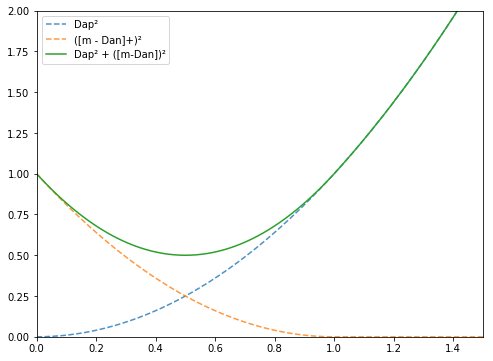

In [2]:
figure(num=None, figsize=(8,6)) #, dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
X = np.linspace(0, 3, 800, endpoint=True)

plt.plot(X, X**2,'--', alpha=0.8, label ='Dap²')
plt.plot(X, np.maximum((1-X),0)**2, '--', alpha=0.8,label ='([m - Dan]+)²')
plt.plot(X, X**2 + np.maximum((1-X),0)**2, label ='Dap² + ([m-Dan])²')

axes.set_xlim([0,1.5])
axes.set_ylim([0,2])
plt.legend()
plt.show()

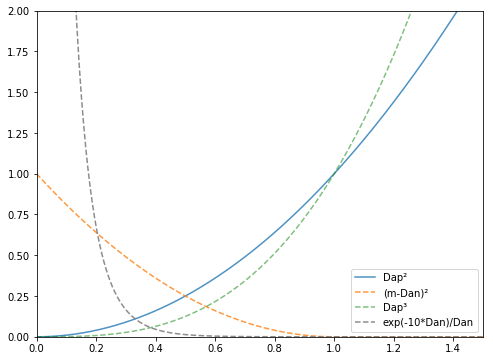

In [3]:
figure(num=None, figsize=(8,6)) #, dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()

X = np.linspace(0, 3, 800, endpoint=True)
#plt.plot(X, X**2 + np.maximum((1-X),0)**2, label ='Dap² + ([m-Dan])²')
plt.plot(X, X**2,'-', alpha=0.8, label ='Dap²')
plt.plot(X, np.maximum((1-X),0)**2, '--', alpha=0.8,label ='(m-Dan)²')

c=['blue','red', 'green', 'purple']
i=0
for m in [10]:
    for p in [3]:
        #plt.plot(X, np.exp(-m*X)/X + X**p, color = c[i],label = 'exp(-''{}''x)/x + x^''{}'.format(m,p))
        plt.plot(X, X**p, '--',color='green', alpha=0.5,label = 'Dap³' )#'x^''{}'.format(p))
        i+=1
    plt.plot(X, np.exp(-m*X)/X,'--',color='gray', alpha=0.9,label = 'exp(-''{}''*Dan)/Dan'.format(m))
 
axes.set_xlim([0,1.5])
axes.set_ylim([0,2])
plt.legend()
plt.show()

In [4]:
num_classes = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

In [5]:
#create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)] 
#tr_pairs_lbs = [y_train[i] for i in digit_indices]
tr_pairs, tr_y, tr_pairs_lbs = create_pairs(x_train,y_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y, te_pairs_lbs = create_pairs(x_test,y_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# the weights are shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)


distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])


def embedding(inputs,base_network):
    intermediate_layer_model = Model(inputs=base_network.get_input_at(0),
                                 outputs=base_network.get_output_at(0))
    return intermediate_layer_model.predict(inputs)




In [6]:
model = Model([input_a, input_b], distance)
model.save_weights('model.h5')
base_network.save_weights('bn.h5')
model.summary()
base_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          133504      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [8]:
#train_set = np.vstack([tr_pairs[:, 0],tr_pairs[:, 1]])
#train_labels = np.hstack([tr_pairs_lbs[:, 0],tr_pairs_lbs[:, 1]])
#test_set = np.vstack([te_pairs[:, 0],te_pairs[:, 1]])
#test_labels = np.hstack([te_pairs_lbs[:, 0],te_pairs_lbs[:, 1]])

### t-SNE plot of 1000 random points in the test set


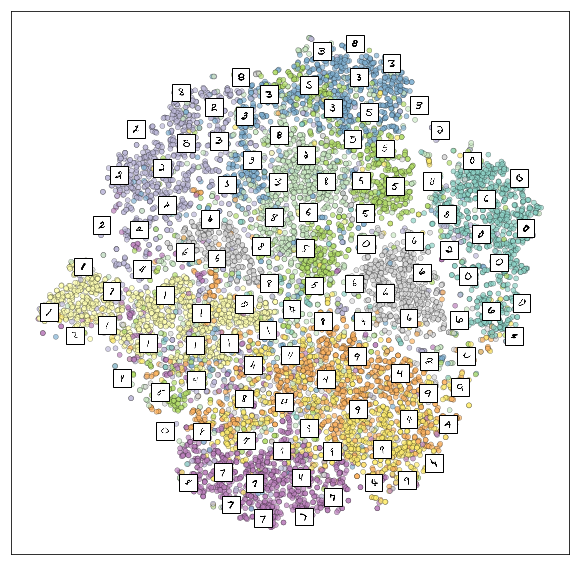

In [10]:
base_network.load_weights('bn.h5')
plot_emb(embedding(x_test,base_network), x_test, y_test,10000)

In [7]:
def train(loss=contrastive_loss, opt=RMSprop(), epcs=2, bs=256, reset_weights=True):
    
    if reset_weights==True:
        model.load_weights('model.h5')  
        base_network.load_weights('bn.h5')  
        print('Norm pre-training', np.linalg.norm(model.get_weights()[0],'fro'))
        #print('BN Norm pre-training', np.linalg.norm(base_network.get_weights()[0],'fro'))
        # BN norm is the same as model,as expected

    model.compile(loss=loss, optimizer=opt, metrics= [accuracy])
    model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=bs,
          epochs=epcs)
    
    return model#, base_network

# Contrastive loss

In [8]:
cmodel = train(loss=contrastive_loss, opt=RMSprop(), epcs=40, bs=128, reset_weights=True)

base_network.save_weights('contrastive_base_network.h5')
#cmodel.save_weights('contrastive_base_network.h5')
contrast_pred= cmodel.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, contrast_pred)
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))
print('Norm after training', np.linalg.norm(cmodel.get_weights()[0],'fro'))
print('BN Norm after-training', np.linalg.norm(base_network.get_weights()[0],'fro'))

Norm pre-training 14.803372
Epoch 1/40
108400/108400 [==============================] - 18s 162us/step - loss: 0.0949 - accuracy: 0.8887
Epoch 2/40
108400/108400 [==============================] - 17s 157us/step - loss: 0.0407 - accuracy: 0.9617
Epoch 3/40
108400/108400 [==============================] - 17s 155us/step - loss: 0.0274 - accuracy: 0.9741
Epoch 4/40
108400/108400 [==============================] - 17s 159us/step - loss: 0.0218 - accuracy: 0.9785
Epoch 5/40
108400/108400 [==============================] - 18s 164us/step - loss: 0.0183 - accuracy: 0.9811
Epoch 6/40
108400/108400 [==============================] - 18s 166us/step - loss: 0.0158 - accuracy: 0.9835
Epoch 7/40
108400/108400 [==============================] - 33s 304us/step - loss: 0.0141 - accuracy: 0.9852
Epoch 8/40
108400/108400 [==============================] - 22s 206us/step - loss: 0.0130 - accuracy: 0.9865
Epoch 9/40
108400/108400 [==============================] - 44s 403us/step - loss: 0.0119 - accuracy

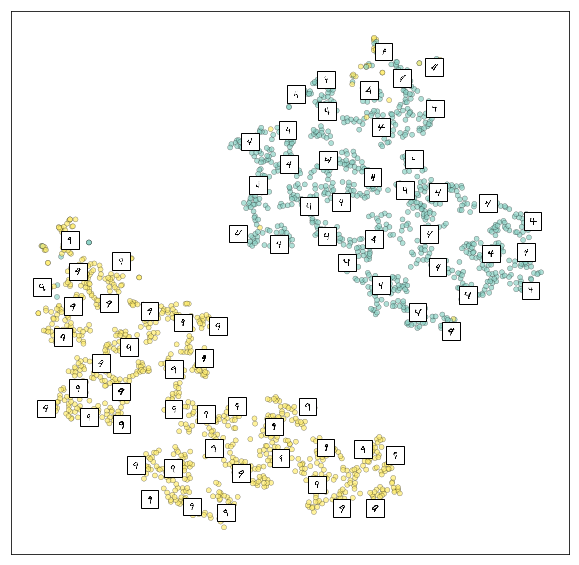

In [27]:
test49 = np.array([x_test[i] for i in range(len(x_test)) if y_test[i] in [4,9]])
labels49 = [y_test[i] for i in range(len(y_test)) if y_test[i] in [4,9]]

loss_name='contrastive'
base_network.load_weights(str(loss_name)+'_base_network.h5')
plot_emb(embedding(test49,base_network), test49, labels49,len(test49),'_49_40epcs_128'+loss_name)

#fig.savefig('plot.png')

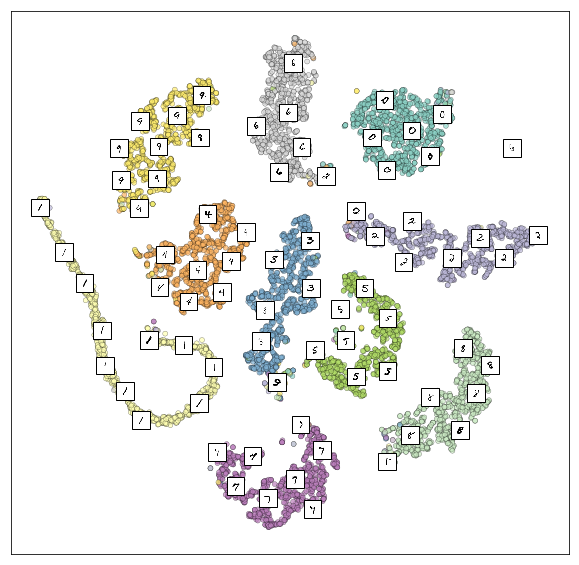

In [28]:
loss_name='contrastive'
base_network.load_weights(str(loss_name)+'_base_network.h5')
plot_emb(embedding(x_test,base_network), x_test, y_test,10000,'_40epcs_128'+loss_name)

dist_plot(te_pairs_lbs, contrast_pred)

# Potential loss

In [29]:
pmodel = train(loss=potential_loss, opt=RMSprop(), epcs=40, bs=128, reset_weights=True)

base_network.save_weights('potential_base_network.h5')
pot_pred = pmodel.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, pot_pred)
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))
print('Norm after training', np.linalg.norm(pmodel.get_weights()[0],'fro'))

Norm pre-training 14.803372
Epoch 1/40
108400/108400 [==============================] - 49s 454us/step - loss: 0.0329 - accuracy: 0.8212
Epoch 2/40
108400/108400 [==============================] - 32s 295us/step - loss: 0.0136 - accuracy: 0.9350
Epoch 3/40
108400/108400 [==============================] - 39s 359us/step - loss: 0.0091 - accuracy: 0.9620
Epoch 4/40
108400/108400 [==============================] - 49s 452us/step - loss: 0.0070 - accuracy: 0.9756
Epoch 5/40
108400/108400 [==============================] - 18s 163us/step - loss: 0.0058 - accuracy: 0.9814
Epoch 6/40
108400/108400 [==============================] - 54s 497us/step - loss: 0.0051 - accuracy: 0.9845
Epoch 7/40
108400/108400 [==============================] - 43s 393us/step - loss: 0.0044 - accuracy: 0.9873
Epoch 8/40
108400/108400 [==============================] - 23s 211us/step - loss: 0.0041 - accuracy: 0.9891
Epoch 9/40
108400/108400 [==============================] - 47s 434us/step - loss: 0.0040 - accuracy

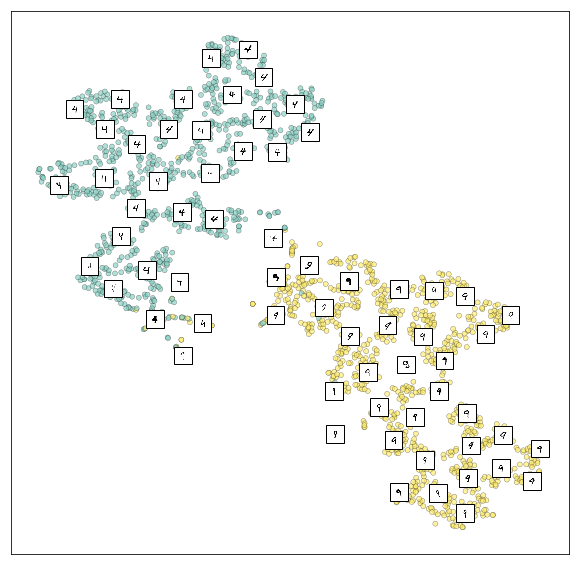

In [30]:
loss_name='potential'
base_network.load_weights(str(loss_name)+'_base_network.h5')
plot_emb(embedding(test49,base_network), test49, labels49,len(test49),'_49_40epcs_128'+loss_name)


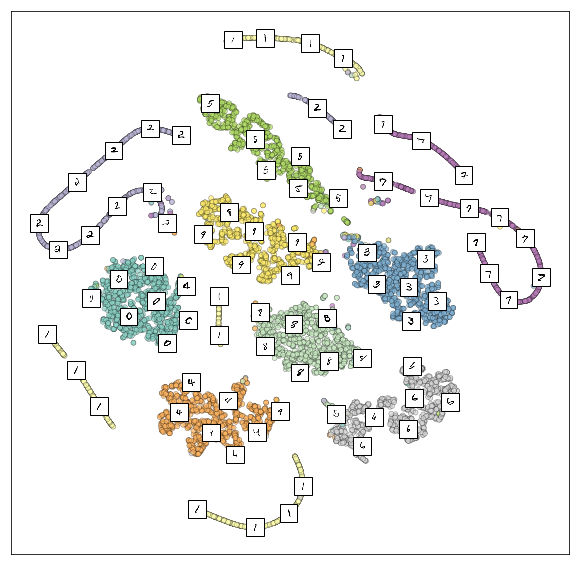

In [31]:
loss_name='potential'
base_network.load_weights(str(loss_name)+'_base_network.h5')
plot_emb(embedding(x_test,base_network), x_test, y_test,10000,'_40epcs_128'+loss_name)

<Figure size 576x576 with 0 Axes>

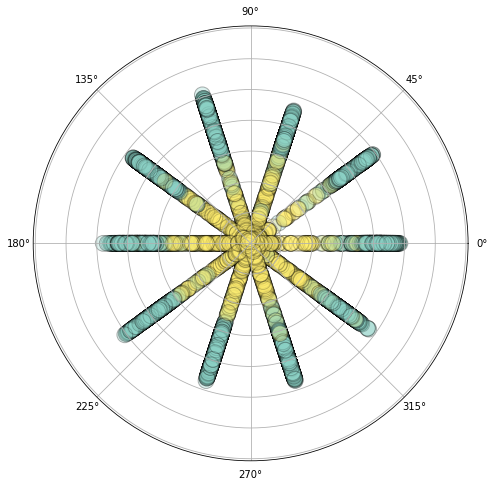

In [26]:
dist_plot(te_pairs_lbs, pot_pred)

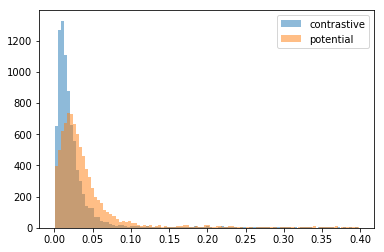

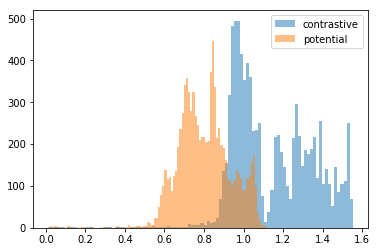

<Figure size 432x288 with 0 Axes>

In [38]:
ceqs = [contrast_pred[i][0] for i in range(len(te_y)) if te_y[i]==1]
cdifs = [contrast_pred[i][0] for i in range(len(te_y)) if te_y[i]==0]

peqs = [pot_pred[i][0] for i in range(len(te_y)) if te_y[i]==1]
pdifs = [pot_pred[i][0] for i in range(len(te_y)) if te_y[i]==0]


ceqs = [contrast_pred[i][0] for i in range(len(te_y)) if te_y[i]==1 and  contrast_pred[i][0]<0.4 ]
peqs = [pot_pred[i][0] for i in range(len(te_y)) if te_y[i]==1 and  pot_pred[i][0]<0.4 ]




plt.hist(ceqs, bins=100,alpha=0.5, label='contrastive')
plt.hist(peqs, bins=100,alpha=0.5, label='potential')
plt.legend(loc='upper right')
plt.show()
plt.savefig('images/dist_positive_40epcs_128.png')


plt.hist(cdifs, bins=100, alpha=0.5, label='contrastive')
plt.hist(pdifs, bins=100, alpha=0.5, label='potential')
plt.legend(loc='upper right')
plt.show()
plt.savefig('images/dist_negative_40epcs_128.png')


In [36]:
print(np.mean(ceqs))
print(np.std(ceqs))

print(np.mean(peqs))
print(np.std(peqs))

0.026802318
0.04401467
0.041577548
0.052358694


In [37]:
print(np.mean(cdifs))
print(np.std(cdifs))

print(np.mean(pdifs))
print(np.std(pdifs))

1.1446075
0.20582794
0.8033665
0.13467307
